/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-10-20 15:30:14.028021: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-20 15:30:14.808263: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-10-20 15:30:14.808318: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinf

Finish initialization...
Finish initialization...
Successfully load the DVI visualization model for iteration 200
Computing decision regions ...
Successfully load the DVI visualization model for iteration 200
Successfully load the DVI visualization model for iteration 200


100%|██████████| 250/250 [00:00<00:00, 7489.40it/s]


Successfully load the DVI visualization model for iteration 200


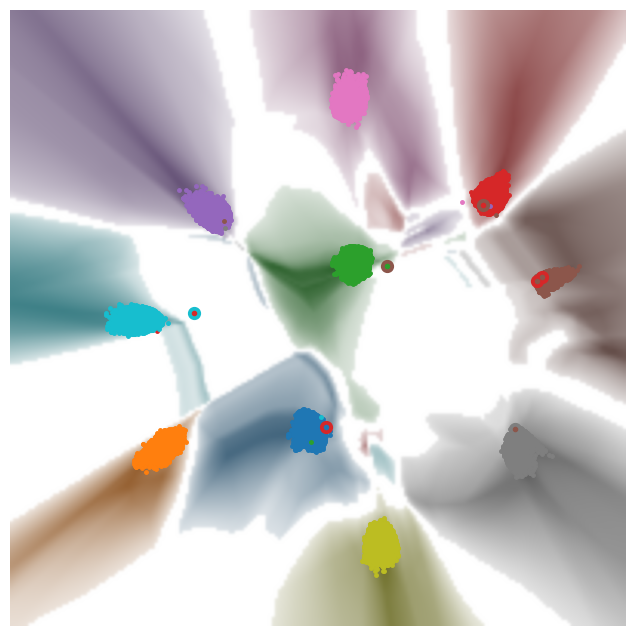

In [1]:
########################################################################################################################
#                                                          IMPORT                                                      #
########################################################################################################################
import torch
import sys
import os
import json
import time
import numpy as np
import argparse
sys.path.append("/home/yifan/projects/cophi/ContraVis")

from umap.umap_ import find_ab_params
from contrast.transfomration import *

from singleVis.SingleVisualizationModel import VisModel
from singleVis.losses import UmapLoss, ReconstructionLoss, SingleVisLoss

from singleVis.data import NormalDataProvider


from singleVis.projector import DVIProjector,ContraProjector
from singleVis.utils import find_neighbor_preserving_rate

########################################################################################################################
#                                                      PARAMETERS                                                   #
########################################################################################################################
"""This serve as an example of DeepVisualInsight implementation in pytorch."""
VIS_METHOD = "DVI" # DeepVisualInsight


TAR_PATH = "/home/yifan/experiments/backdoor/resnet18_CIFAR10/experiment10"
REF_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"

########################################################################################################################
#                                                     LOAD PARAMETERS                                                  #
########################################################################################################################


CONTENT_PATH = REF_PATH
sys.path.append(CONTENT_PATH)
with open(os.path.join(CONTENT_PATH, "config.json"), "r") as f:
    config = json.load(f)
config = config[VIS_METHOD]

# record output information
# now = time.strftime("%Y-%m-%d-%H_%M_%S", time.localtime(time.time())) 
# sys.stdout = open(os.path.join(CONTENT_PATH, now+".txt"), "w")

SETTING = config["SETTING"]
CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
PREPROCESS = config["VISUALIZATION"]["PREPROCESS"]
GPU_ID = config["GPU"]
GPU_ID = 1
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]

EPOCH_START = 200
EPOCH_END = 200
EPOCH_PERIOD = 1

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
LAMBDA1 = VISUALIZATION_PARAMETER["LAMBDA1"]
LAMBDA2 = VISUALIZATION_PARAMETER["LAMBDA2"]
B_N_EPOCHS = VISUALIZATION_PARAMETER["BOUNDARY"]["B_N_EPOCHS"]
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]


S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]

VIS_MODEL_NAME = 'Contravis_backdoor' ### saved_as 
EVALUATION_NAME = VISUALIZATION_PARAMETER["EVALUATION_NAME"]

# Define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))

########################################################################################################################
#                                                    TRAINING SETTING                                                  #
########################################################################################################################
# Define data_provider
#TODO
TAE_NET = "resnet18"
tar_net = eval("subject_model.{}()".format(TAE_NET)) 

data_provider = NormalDataProvider(CONTENT_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, device=DEVICE, epoch_name='Epoch',classes=CLASSES,verbose=1)
tar_data_provider = NormalDataProvider(TAR_PATH, tar_net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, device=DEVICE, epoch_name='Epoch',classes=CLASSES,verbose=1)


# Define visualization models
model = VisModel(ENCODER_DIMS, DECODER_DIMS)


# Define Losses
negative_sample_rate = 5
min_dist = .1
_a, _b = find_ab_params(1.0, min_dist)
umap_loss_fn = UmapLoss(negative_sample_rate, DEVICE, _a, _b, repulsion_strength=1.0)
recon_loss_fn = ReconstructionLoss(beta=1.0)
single_loss_fn = SingleVisLoss(umap_loss_fn, recon_loss_fn, lambd=LAMBDA1)
# Define Projector
projector = ContraProjector(vis_model=model, content_path=os.path.join(REF_PATH, 'Model', 'Epoch_{}//Contravis.pth'.format(EPOCH_START)), vis_model_name=VIS_MODEL_NAME, device=DEVICE)

# projector = ContraProjector(vis_model=model, content_path=os.path.join(REF_PATH, 'Model', 'Epoch_{}//Contravis_backdoor.pth'.format(EPOCH_START)), vis_model_name=VIS_MODEL_NAME, device=DEVICE)

########################################################################################################################
#                                                      VISUALIZATION                                                   #
########################################################################################################################

from singleVis.visualizer import visualizer
now = time.strftime("%Y-%m-%d-%H_%M_%S", time.localtime(time.time())) 
vis = visualizer(data_provider, projector, 200, "tab10")
save_dir = os.path.join(data_provider.content_path, "contraImg")
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

vis.savefig(EPOCH_START, path="./ref.png")

In [9]:
ref_Data = data_provider.train_representation(200)

In [10]:
ref_Data = ref_Data.reshape(ref_Data.shape[0],ref_Data.shape[1])

In [12]:
emb = projector.batch_project(200,ref_Data)

Successfully load the DVI visualization model for iteration 200


In [13]:
np.save(os.path.join('./11embedding.npy' ), emb)

In [5]:
x_min, y_min, x_max, y_max

(-30.899277, -30.899277, 42.430016, 42.430016)

In [6]:
np.save('./scale.npy',[-30.899277, -30.899277, 42.430016, 42.430016])

Successfully load the DVI visualization model for iteration 200
Computing decision regions ...
Successfully load the DVI visualization model for iteration 200
Successfully load the DVI visualization model for iteration 200


100%|██████████| 200/200 [00:00<00:00, 5666.75it/s]


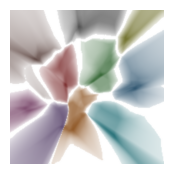

In [4]:

x_min, y_min, x_max, y_max, b_fig = vis.get_background(200,200)

Successfully load the DVI visualization model for iteration 200
Computing decision regions ...
Successfully load the DVI visualization model for iteration 200
Successfully load the DVI visualization model for iteration 200


100%|██████████| 250/250 [00:00<00:00, 7474.45it/s]


Successfully load the DVI visualization model for iteration 200
Successfully load the DVI visualization model for iteration 200
Computing decision regions ...
Successfully load the DVI visualization model for iteration 200
Successfully load the DVI visualization model for iteration 200


100%|██████████| 200/200 [00:00<00:00, 8402.22it/s]


saved as /home/yifan/experiments/backdoor/resnet18_CIFAR10/experiment10/Model/Epoch_200/bgimg.png


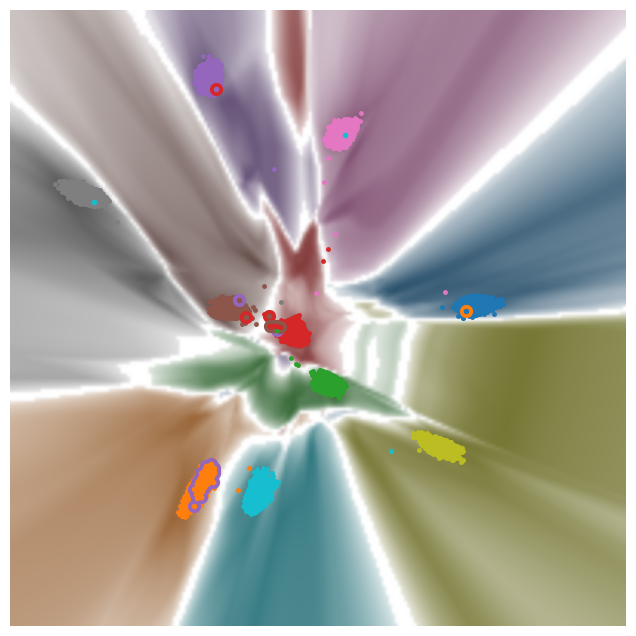

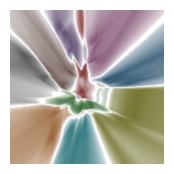

In [6]:

from singleVis.visualizer_for_tar import visualizer

p = os.path.join(REF_PATH, 'Model', 'Epoch_{}//trans_model.m'.format(EPOCH_START))
transed_model = torch.load(p).to(DEVICE)
now = time.strftime("%Y-%m-%d-%H_%M_%S", time.localtime(time.time())) 
vis = visualizer(data_provider, tar_data_provider, transed_model, projector, 200,DEVICE, "tab10",True)
save_dir = os.path.join(data_provider.content_path, "contraImg")
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
for i in range(EPOCH_START, EPOCH_END+1, EPOCH_PERIOD):
    vis.savefig(i, path= "./tar.png")
    x_min, y_min, x_max, y_max, b_fig = vis.get_background(i,200)

In [5]:
np.save('./scale.npy',[-23.325905, -23.325905, 38.10333, 38.10333])

In [10]:
data = torch.load('/home/yifan/dataset/backdoor_demo/Training_data/training_dataset_data.pth')

In [11]:
data.shape

torch.Size([50000, 3, 32, 32])

In [4]:
x_min, y_min, x_max, y_max

(-23.325905, -23.325905, 38.10333, 38.10333)

In [5]:
emb = projector.batch_project(200, transed_model.encoder(torch.Tensor(tar_data_provider.train_representation(200))))

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:1! (when checking argument for argument mat2 in method wrapper_mm)

In [ ]:
path = '/home/yifan/dataset/backdoor_demo/Model/Epoch_200'

Successfully load the DVI visualization model for iteration 200
Computing decision regions ...
Successfully load the DVI visualization model for iteration 200
Successfully load the DVI visualization model for iteration 200


100%|██████████| 250/250 [00:00<00:00, 7494.00it/s]


Successfully load the DVI visualization model for iteration 200


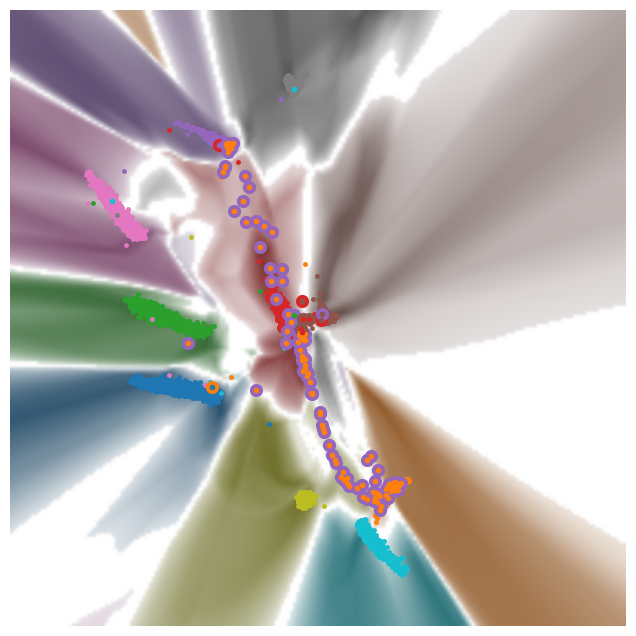

In [3]:

from singleVis.visualizer_for_tar import visualizer

transed_model = torch.load('./trans_model.m').to(DEVICE)
now = time.strftime("%Y-%m-%d-%H_%M_%S", time.localtime(time.time())) 
vis = visualizer(data_provider, tar_data_provider, transed_model, projector, 200,DEVICE, "tab10",True)
save_dir = os.path.join(data_provider.content_path, "contraImg")
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
for i in range(EPOCH_START, EPOCH_END+1, EPOCH_PERIOD):
    vis.savefig(i, path= "./tar.png")

Successfully load the DVI visualization model for iteration 200
Computing decision regions ...
Successfully load the DVI visualization model for iteration 200
Successfully load the DVI visualization model for iteration 200


100%|██████████| 250/250 [00:00<00:00, 7488.87it/s]


Successfully load the DVI visualization model for iteration 200


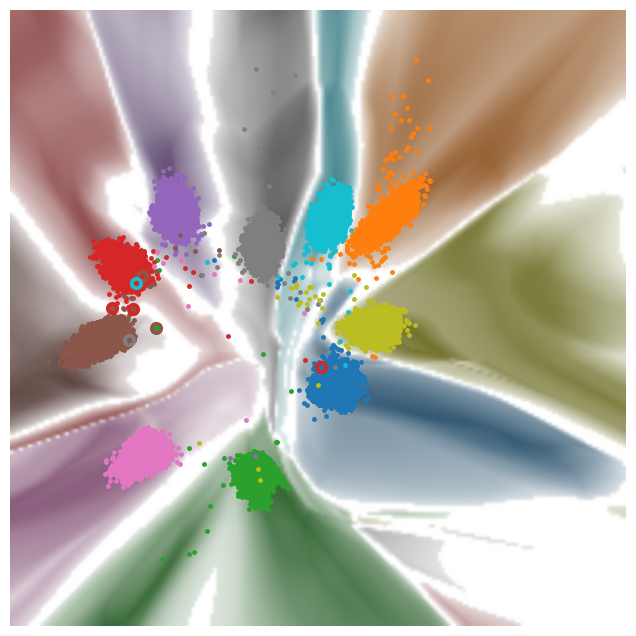

In [3]:
projector = ContraProjector(vis_model=model, content_path=os.path.join('./Contravis.pth'), vis_model_name=VIS_MODEL_NAME, device=DEVICE)

########################################################################################################################
#                                                      VISUALIZATION                                                   #
########################################################################################################################

from singleVis.visualizer import visualizer
now = time.strftime("%Y-%m-%d-%H_%M_%S", time.localtime(time.time())) 
vis = visualizer(data_provider, projector, 200, "tab10")
save_dir = os.path.join(data_provider.content_path, "contraImg")
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

vis.savefig(EPOCH_START, path="./ref.png")

In [30]:
with open(os.path.join(REF_PATH, "clean_label.json"), "r") as f:
    clean = json.load(f)

with open(os.path.join(REF_PATH, "noisy_label.json"), "r") as f:
    noise = json.load(f)

In [31]:
diff_indexs=[]
same1= []
same4= []
for i in range(len(clean)):
    if clean[i] != noise[i]:
        diff_indexs.append(i)
    if clean[i] == noise[i] and clean[i] == 1:
        same1.append(i)
    if clean[i] == noise[i] and clean[i] == 4:
        same4.append(i)



In [18]:
clean[28] # 4
noise[28] # 1

1

In [32]:
from sklearn.cluster import KMeans
data = ref_Data[diff_indexs]
print(len(diff_indexs))
# 初始化KMeans对象，n_clusters为聚类数量
kmeans = KMeans(n_clusters=1)

# 训练模型
kmeans.fit(data)

# 获取聚类中心
cluster_centers = kmeans.cluster_centers_


500
[[1.04199378e-02 2.70140111e-01 5.81580587e-02 4.10352182e-03
  1.30522903e-02 7.41717875e-01 2.52873570e-01 3.09198827e-01
  6.53849095e-02 7.14400737e-03 5.07425983e-03 1.49271458e-01
  6.41600415e-02 1.67287663e-02 6.15349272e-03 1.34383962e-02
  4.69021164e-02 7.05342367e-03 2.37603635e-02 3.32508802e-01
  4.91666406e-01 1.18634123e-02 7.75624514e-02 2.08906252e-02
  1.16283000e-01 3.53326648e-03 6.41739249e-01 2.56353505e-02
  3.40447389e-02 3.63564491e-02 6.12481713e-01 1.75489224e-02
  1.25062013e+00 6.37291908e-01 1.07664242e-02 2.14486927e-01
  1.85554326e-02 5.78693271e-01 1.90714136e-01 2.07541976e-03
  4.22066152e-02 1.21107197e+00 1.13008723e-01 2.53313661e-01
  4.91070062e-01 1.65583551e-01 7.88696632e-02 1.97077747e-02
  5.99521212e-02 2.29623076e-02 2.63458341e-02 1.00727091e-02
  2.79599518e-01 2.18532085e-01 2.66667120e-02 5.98117560e-02
  6.45367941e-03 2.49769434e-01 1.99767314e-02 1.89983845e-02
  6.97190035e-03 4.52829808e-01 1.99975185e-02 4.99731256e-03
  9.

In [33]:
data = ref_Data[same1]
print(len(same1))
# 初始化KMeans对象，n_clusters为聚类数量
kmeans = KMeans(n_clusters=1)

# 训练模型
kmeans.fit(data)

# 获取聚类中心
cluster_centers1 = kmeans.cluster_centers_


5000


In [39]:
distance_AB = np.linalg.norm(cluster_centers1 - cluster_centers4)
distance_AB

7.9898386

In [37]:
distance_AB

1.2357099

In [35]:
data = ref_Data[same4]
print(len(same4))
# 初始化KMeans对象，n_clusters为聚类数量
kmeans = KMeans(n_clusters=1)

# 训练模型
kmeans.fit(data)

# 获取聚类中心
cluster_centers4 = kmeans.cluster_centers_

4500


array([[2.7404487e-01, 3.1459099e-01, 4.2812043e-01, ..., 9.7358366e-03,
        3.7254858e-01, 4.6130145e-01],
       [3.2717624e-01, 3.2104298e-02, 8.6732268e-01, ..., 1.1300426e-02,
        5.5804694e-01, 2.4555829e-01],
       [3.2717624e-01, 3.2104298e-02, 8.6732268e-01, ..., 1.1300426e-02,
        5.5804694e-01, 2.4555829e-01],
       ...,
       [3.2717624e-01, 3.2104298e-02, 8.6732268e-01, ..., 1.1300426e-02,
        5.5804694e-01, 2.4555829e-01],
       [4.3135577e-01, 1.9788682e-03, 1.2517633e-01, ..., 2.3667835e-02,
        1.9429460e-01, 1.2701980e-04],
       [4.3135577e-01, 1.9788682e-03, 1.2517633e-01, ..., 2.3667835e-02,
        1.9429460e-01, 1.2701980e-04]], dtype=float32)

In [16]:
diff_indexs

[28,
 66,
 86,
 414,
 434,
 526,
 528,
 632,
 674,
 711,
 939,
 959,
 1148,
 1169,
 1203,
 1268,
 1299,
 1303,
 1347,
 1348,
 1373,
 1425,
 1450,
 1491,
 1855,
 1880,
 2123,
 2190,
 2225,
 2238,
 2418,
 2486,
 2515,
 2904,
 2926,
 2976,
 3046,
 3189,
 3217,
 3283,
 3300,
 3354,
 3494,
 3577,
 3684,
 3695,
 3821,
 3919,
 3952,
 4055,
 4058,
 4227,
 4232,
 4381,
 4400,
 4710,
 5063,
 5074,
 5237,
 5264,
 5342,
 5490,
 5624,
 5677,
 6266,
 6289,
 6292,
 6465,
 6527,
 6562,
 6894,
 6911,
 6940,
 6950,
 6983,
 7218,
 7368,
 7382,
 7386,
 7424,
 7733,
 7743,
 7896,
 7963,
 8114,
 8415,
 8472,
 8504,
 8523,
 8582,
 8720,
 8899,
 8905,
 8930,
 9061,
 9083,
 9259,
 9359,
 9441,
 9529,
 9593,
 9638,
 9695,
 9845,
 9950,
 10105,
 10134,
 10210,
 10264,
 10472,
 10489,
 10519,
 10605,
 10633,
 10661,
 10719,
 10720,
 10736,
 10951,
 11020,
 11064,
 11118,
 11254,
 11769,
 11807,
 11810,
 11862,
 11930,
 12094,
 12285,
 12331,
 12489,
 12505,
 12510,
 12522,
 12530,
 12580,
 12611,
 12636,
 12663,
